In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix,accuracy_score
import tensorflow as tf
import torch

# Making the dataloader#

In [ ]:
# imports
import torchvision
from torch.utils.data import Dataset
from PIL import Image
import os
import csv

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import time
import copy
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# new
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [ ]:
class CSVDataLoader:
    def __init__(self, file_path, split, transform = None):
        self.split = split
        # self.data = self.load_csv_file(file_path)
        self.df = pd.read_csv(file_path)
        self.transform = transform

    # def load_csv_file(self, file_path):
    #     data = []
    #     with open(file_path, 'r', newline='') as csvfile:
    #         csvreader = csv.reader(csvfile)
    #         for row in csvreader:
    #             data.append(row)
    #     return data

    # Returns image, label
    def __getitem__(self, index):
        image_id = self.df.loc[index, "ImageID"]
        label = 1 if self.df.loc[index, "abnormal"] else 0
        if label:
          image_dir = "abnormal"
        else:
          image_dir = "normal"

        # image = Image.open(f'/content/drive/My Drive/Neuro140/padchest/{image_dir}/{image_id}')
        image = Image.open(f'data{image_id}')
        # display(image)
        # Convert grayscale image to RGB
        image = image.convert("RGB")

        if self.transform:
          image = self.transform(image)

        # return self.data[index]
        return image, label

    def __len__(self):
        return self.df.shape[0]
        # return len(self.data)

# Example usage:
# csv_file_path = '/content/drive/My Drive/Neuro140/spain/spain_selected.csv'  # Path to your CSV file
# data_loader = CSVDataLoader(csv_file_path, 'train')

# # Iterating through the data loader
# for row in data_loader:
#     print(row)

# # Accessing individual items
# print(data_loader[0])

In [ ]:
# These transforms that we'll execute in sequence
data_transforms = {
    'train': transforms.Compose([
         transforms.Resize((224, 224)),
         # transforms.RandomResizedCrop(224),
         # transforms.RandomHorizontalFlip(), # Flips image horiontally with 50% probablity
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # [Red, Green, Blue] Color chanells
         # transforms.Resize(224)
     ]),

     'val': transforms.Compose([
         transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
     ]),

     'test': transforms.Compose([
         transforms.Resize((224, 224)),
         # transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
     ])
}


In [ ]:
dsets = {}
dsets["train"] = CSVDataLoader( 'experiment3_train.csv', "train", data_transforms['train'])
dsets["val"] = CSVDataLoader( 'experiment3_val.csv', "val", data_transforms['val'])
dsets["test"] = CSVDataLoader( 'china_selected_test.csv', "test", data_transforms['test']) # save this data to the mac

In [ ]:
# Globals
BATCH_SIZE = 32

In [ ]:
dset_sizes = {split: len(dsets[split]) for split in ['train', 'val', 'test']}

In [ ]:
dset_loaders = {}
dset_loaders["train"] = torch.utils.data.DataLoader(dsets["train"], batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)
dset_loaders["val"] = torch.utils.data.DataLoader(dsets["val"], batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)
dset_loaders["test"] = torch.utils.data.DataLoader(dsets["test"], batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)
# for split in ['train', 'val']:
#   dset_loaders[split] = torch.utils.data.DataLoader(dsets[split], batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)

In [ ]:
for batch_data, batch_targets in dset_loaders['train']:
    print("here")
    # print(f"batch data {batch_data}")
    # print(f"batch targets {batch_targets}")

here


KeyboardInterrupt: 

# Attempt to Define a Model

In [ ]:
# TRAINING SETTINGS
NUM_EPOCHS = 7


# LEARNING RATE SETTINGS
BASE_LR = 0.0001 # originally 0.001
DECAY_WEIGHT = 0.1 # factor by which the learning rate is reduced.
EPOCH_DECAY = 30 # number of epochs after which the learning rate is decayed exponentially by DECAY_WEIGHT.


# DATASET INFO
NUM_CLASSES = 2 # set the number of classes in your dataset
# DATA_DIR = 'biased_cars_1/' # to run with the sample dataset, just set to 'hymenoptera_data'


# DATALOADER PROPERTIES
BATCH_SIZE = 32 # originally 10


# GPU SETTINGS
CUDA_DEVICE = 0 # Enter device ID of your gpu if you want to run on gpu. Otherwise neglect.
# Set to 1 to use GPU if on google colab
GPU_MODE = 1 # set to 1 if want to run on gpu.


# SETTINGS FOR DISPLAYING ON TENSORBOARD
USE_TENSORBOARD = 0 #if you want to use tensorboard set this to 1.
TENSORBOARD_SERVER = "YOUR TENSORBOARD SERVER ADDRESS HERE" # If you set.
EXP_NAME = "fine_tuning_experiment" # if using tensorboard, enter name of experiment you want it to be displayed as.

In [ ]:
## If you want to use the GPU, set GPU_MODE TO 1 in config file
use_gpu = GPU_MODE
if use_gpu:
    torch.cuda.set_device(CUDA_DEVICE)

In [ ]:
! nvidia-smi

Mon Apr 22 03:21:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       On  | 00000000:00:1E.0 Off |                    0 |
| N/A   27C    P0              25W /  70W |    551MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch.nn as nn
from collections import OrderedDict

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=1000):
        super(SimpleCNN, self).__init__()
        self.num_classes = num_classes
        self.model = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3,224,1)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.AvgPool2d(4)),
            ('conv2', nn.Conv2d(224,32,1)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.AvgPool2d(16)),
            ('flatten', nn.Flatten()),
            ('fc', nn.Linear(288,num_classes)),
        ]))

    def forward(self, x):
        return self.model(x)


In [ ]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=100):
    since = time.time()

    best_model = model
    best_acc = 0.0

    accuracies = {'train': [], 'val': []}
    losses = {'train': [], 'val': []}
    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to eval mode for validation (no need to track gradients)

            running_loss = 0.0
            running_corrects = 0

            counter=0

            # NEW
            # Initialize variables to store false positives and false negatives
            false_positives = 0
            false_negatives = 0
            true_positives = 0

            # Iterate over data, getting one batch of inputs (images) and labels each time.

            for data in dset_loaders[phase]:
                inputs, labels = data

                if use_gpu:
                    try:
                        inputs, labels = Variable(inputs.float().cuda()), Variable(labels.long().cuda())
                    except Exception as e:
                        print("ERROR! here are the inputs and labels before we print the full stack trace:")
                        print(inputs, labels)
                        raise e
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # Set gradient to zero to delete history of computations in previous epoch. Track operations so that differentiation can be done automatically.
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                # Print a line every 10 batches so you have something to watch and don't feel like the program isn't running.
                if counter%10==0:
                    print("Reached batch iteration", counter)

                counter+=1

                # NEW
                # # Count false positives and false negatives
                # if phase == 'test':
                #     false_positives += torch.sum((preds == 1) & (labels.data == 0)).item()
                #     false_negatives += torch.sum((preds == 0) & (labels.data == 1)).item()
                #     true_positives += torch.sum((preds == 1) & (labels.data == 1)).item()


                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                try:
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
                except:
                    print('unexpected error, could not calculate loss or do a sum.')

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects.item() / float(dset_sizes[phase])
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            accuracies[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)


            # Print false positives and false negatives for test phase
            # if phase == 'val':
            #     sensitivity = true_positives / (true_positives + false_negatives)
            #     print('Sensitivity:', sensitivity)
            #     print('False Positives:', false_positives)
            #     print('False Negatives:', false_negatives)

            # deep copy the model
            if phase == 'val':
                if USE_TENSORBOARD:
                    foo.add_scalar_value('epoch_loss', epoch_loss,step=epoch)
                    foo.add_scalar_value('epoch_acc', epoch_acc,step=epoch)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = copy.deepcopy(model)
                    print('new best accuracy =', best_acc)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('returning and looping back')

    return best_model, accuracies, losses


# This function changes the learning rate as the model trains.
# If the learning rate is too high, training tends to be unstable and it's harder to converge on an optimal set of weights.
# But, if learning rate is too low, learning is too slow and you won't converge in a reasonable time frame. A good compromise
# is to start out with a high learning rate and then reduce it over time.
def exp_lr_scheduler(optimizer, epoch, init_lr=BASE_LR, lr_decay_epoch=EPOCH_DECAY):
    """Decay learning rate by a factor of DECAY_WEIGHT every lr_decay_epoch epochs."""
    lr = init_lr * (DECAY_WEIGHT**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [ ]:
### SECTION 4 - DEFINING MODEL ARCHITECTURE.

##################
# MODIFIED: Added
# Set the number of classes in the config file by setting the right value for NUM_CLASSES.
##################
# model_ft = SimpleCNN(num_classes=NUM_CLASSES)


#---> Just uncomment these lines to use ResNet18
##################
# MODIFIED: Deleted
# We use Resnet18 here. If you have more computational power, feel free to swap it with Resnet50, Resnet100 or Resnet152.
# For fine tuning or transfer learning, we will use the pretrained net weights.
##################
model_ft = models.resnet18(pretrained = True) # pretrained = True is deprecated
# Freeze all the parameters in the convolutional layers
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)


criterion = nn.CrossEntropyLoss()

if use_gpu:
    criterion.cuda()
    model_ft.cuda()

optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=0.0001)


# Run the functions and save the best model in the function model_ft.
model_ft, accuracies, losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

for split in ['train', 'val']:
    print(split, "accuracies by epoch:", accuracies[split])
    print(split, "losses by epoch:", losses[split])

# Save model
torch.save(model_ft.state_dict(), 'fine_tuned_best_model.pt')


/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
Epoch 0/6
----------
LR is set to 0.0001
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
Reached batch iteration 40
Reached batch iteration 50
Reached batch iteration 60
Reached batch iteration 70
Reached batch iteration 80
Reached batch iteration 90
Reached batch iteration 100
Reached batch iteration 110
Reached batch iteration 120
Reached batch iteration 130
Reached batch iteration 140
Reached batch iteration 150
Reached batch iteration 160
train Loss: 0.0203 Acc: 0.6444
Reached batch iteration 0
Reached batch iteration 10
val Loss: 0.0197 Acc: 0.6350
new best accuracy = 0.635
----------
Epoch 1/6
----------
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
Reached batch iteration 40
Reached batch iteration 50
Reached batch iteration 60
Reached batch iteration 70
Reached batch iteration 80
Reached batch iteration 90
Reached batch iteration 100
Reached batch i

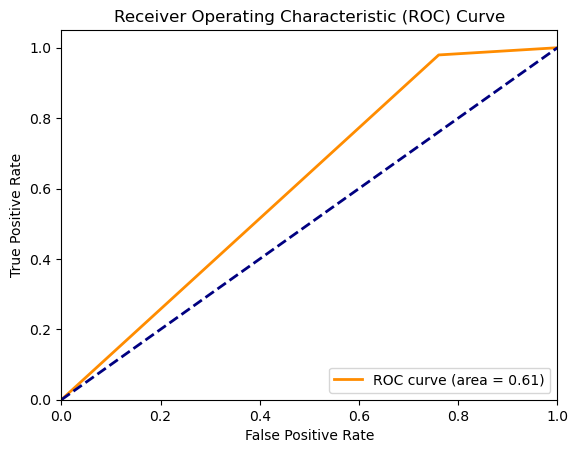

Accuracy: 0.7019230769230769
Precision: 0.6821428571428572
Recall: 0.9794871794871794
F1 Score: 0.8042105263157895
False Positives: 178
False Negatives: 8
Sensitivity: 0.9794871794871794
Specificity: 0.23931623931623933
AUC 0.6094017094017095


In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

def evaluate_model(model, criterion, dataloader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    # Calculate confusion matrix to compute false positives, false negatives, and sensitivity
    conf_matrix = confusion_matrix(all_labels, all_preds)
    TN, FP, FN, TP = conf_matrix.ravel()

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    # Calculate ROC curve and AUC for test data
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    # Save the plot as an image
    # plt.savefig('ROC_plots/roc_curve_experiment3.png')
    plt.show()

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("False Positives:", FP)
    print("False Negatives:", FN)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    print("AUC", roc_auc)

    return accuracy, precision, recall, f1

# Example usage:
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model_ft, criterion, dset_loaders['test'])


## FINE TUNING ##

In [ ]:
def load_weights(model, path):
    model.load_state_dict(torch.load(path))

# Instantiate ResNet18 model without pretrained weights
fine_tuned_model_ft = models.resnet18(pretrained=True)

# Modify the last fully connected layer to match the number of classes in the checkpoint
num_ftrs = fine_tuned_model_ft.fc.in_features
fine_tuned_model_ft.fc = nn.Linear(num_ftrs, 2)  # Assuming you have 2 output classes


# Freeze all the parameters in the convolutional layers
# for param in model_ft.parameters():
#     param.requires_grad = False
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)
# Load trained weights into the model

load_weights(fine_tuned_model_ft, 'fine_tuned_best_model.pt')

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Fine-tuned train and validaiton
dsets = {}
dsets["train"] = CSVDataLoader( 'experiment1_train.csv', "train", data_transforms['train'])
dsets["val"] = CSVDataLoader( 'experiment1_val.csv', "val", data_transforms['val'])
dsets["test"] = CSVDataLoader( 'china_selected_test.csv', "test", data_transforms['test']) # save this data to the mac

In [ ]:
dset_sizes = {split: len(dsets[split]) for split in ['train', 'val', 'test']}

In [ ]:
dset_loaders = {}
dset_loaders["train"] = torch.utils.data.DataLoader(dsets["train"], batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)
dset_loaders["val"] = torch.utils.data.DataLoader(dsets["val"], batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)
dset_loaders["test"] = torch.utils.data.DataLoader(dsets["test"], batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)
# for split in ['train', 'val']:
#   dset_loaders[split] = torch.utils.data.DataLoader(dsets[split], batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)

In [ ]:
torch.backends.cudnn.enabled = False

In [ ]:
NUM_EPOCHS=5
BASE_LR = 0.001 # originally 0.001

In [ ]:
criterion = nn.CrossEntropyLoss()

if use_gpu:
    criterion.cuda()
    fine_tuned_model_ft.cuda()

optimizer_ft = optim.RMSprop(fine_tuned_model_ft.parameters(), lr=0.0001)


# Run the functions and save the best model in the function model_ft.
fine_tuned_model_ft, accuracies, losses = train_model(fine_tuned_model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

for split in ['train', 'val']:
    print(split, "accuracies by epoch:", accuracies[split])
    print(split, "losses by epoch:", losses[split])

# Save model
torch.save(fine_tuned_model_ft.state_dict(), 'fine_tuned_best_model.pt')

----------
Epoch 0/4
----------
LR is set to 0.0001
Reached batch iteration 0
Reached batch iteration 10
train Loss: 0.0077 Acc: 0.9378
Reached batch iteration 0
val Loss: 0.0695 Acc: 0.6000
new best accuracy = 0.6
----------
Epoch 1/4
----------
Reached batch iteration 0
Reached batch iteration 10
train Loss: 0.0085 Acc: 0.9756
Reached batch iteration 0
val Loss: 0.0081 Acc: 0.9000
new best accuracy = 0.9
----------
Epoch 2/4
----------
Reached batch iteration 0
Reached batch iteration 10
train Loss: 0.0016 Acc: 0.9867
Reached batch iteration 0
val Loss: 0.0075 Acc: 0.9000
----------
Epoch 3/4
----------
Reached batch iteration 0
Reached batch iteration 10
train Loss: 0.0021 Acc: 0.9911
Reached batch iteration 0
val Loss: 0.0529 Acc: 0.7800
----------
Epoch 4/4
----------
Reached batch iteration 0
Reached batch iteration 10
train Loss: 0.0059 Acc: 0.9844
Reached batch iteration 0
val Loss: 0.0062 Acc: 0.9400
new best accuracy = 0.94
Training complete in 0m 52s
Best val Acc: 0.940000
r

## Fine tuned test accuracy ##

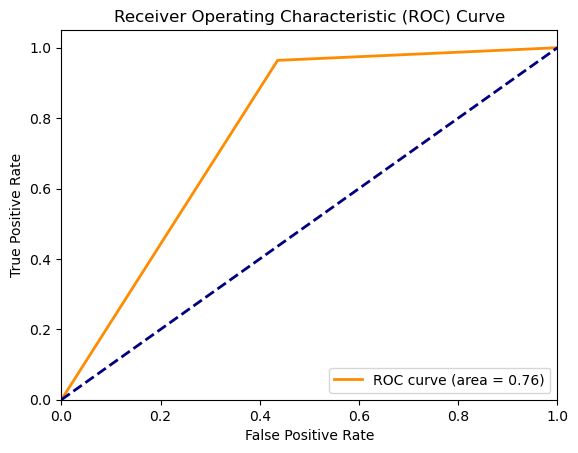

Accuracy: 0.8141025641025641
Precision: 0.7866108786610879
Recall: 0.9641025641025641
F1 Score: 0.8663594470046083
False Positives: 102
False Negatives: 14
Sensitivity: 0.9641025641025641
Specificity: 0.5641025641025641
AUC 0.7641025641025642


In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

def evaluate_model(model, criterion, dataloader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    # Calculate confusion matrix to compute false positives, false negatives, and sensitivity
    conf_matrix = confusion_matrix(all_labels, all_preds)
    TN, FP, FN, TP = conf_matrix.ravel()

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    # Calculate ROC curve and AUC for test data
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    # Save the plot as an image
    plt.savefig('ROC_plots/roc_curve_experiment5.png')
    plt.show()

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("False Positives:", FP)
    print("False Negatives:", FN)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    print("AUC", roc_auc)

    return accuracy, precision, recall, f1

# Example usage:
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(fine_tuned_model_ft, criterion, dset_loaders['test'])


## End of Code ##

In [ ]:
# Define input shape
input_shape = (224, 224, 3)

# # Process the data
# train_generator, test_generator, testData, testLabels = process_data(224, 4)

# Define the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

# Train the model
num_epochs = 10
verbose = 1
steps_per_epoch = len(dsets["train"])
# validation_steps = len(test_generator)

history = model.fit(dset_loaders["train"], steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=verbose)

# # Evaluate the model
# pred = model.predict(testData)
# predicted_labels = np.round(pred)
# accuracy = accuracy_score(testLabels, predicted_labels) * 100

# print("Accuracy: {:.2f}%".format(accuracy))

Reading in the csv

In [ ]:
import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/Neuro140/vinxray/vietnam_train.csv')

# Display the contents of the DataFrame
train_df.head(30)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Neuro140/vinxray/vietnam_train.csv'

In [ ]:
import pandas as pd

# Replace 'your_csv_file.csv' with the actual name of your CSV file
test_df = pd.read_csv('/content/drive/MyDrive/Neuro140/vinxray/vietnam_test.csv')

# Display the contents of the DataFrame
test_df.head()

,Unnamed: 0,full_path,class_name,abnormal
0,13000,./vinxray/train/df908402799fe45e0bac05940e1fcd...,No finding,1
1,13001,./vinxray/train/c35bdb33fed2ba6646c4c5f89ed4ef...,No finding,1
2,13002,./vinxray/train/e8e1f4db5ec4c5ccb4a45c88a2f712...,No finding,1
3,13003,./vinxray/train/e1aabe79bf5c77ec1c14fde6f7d7b7...,No finding,1
4,13004,./vinxray/train/233259480409e87c9e714c425450c3...,No finding,1


In [ ]:
for filename in test_df["full_path"]:
  print(filename)

./vinxray/train/df908402799fe45e0bac05940e1fcd9e.png
./vinxray/train/c35bdb33fed2ba6646c4c5f89ed4ef84.png
./vinxray/train/e8e1f4db5ec4c5ccb4a45c88a2f712b3.png
./vinxray/train/e1aabe79bf5c77ec1c14fde6f7d7b786.png
./vinxray/train/233259480409e87c9e714c425450c333.png
./vinxray/train/113274a4ca3c2e72b7ff1bd3ce5006b6.png
./vinxray/train/50723f9ca4e3cc4b33cac5970f8c442f.png
./vinxray/train/5195e8441de8c3c3651527e293a6bbfc.png
./vinxray/train/2a8b9d2e09ada919e6ce45cb6c451d21.png
./vinxray/train/de3ff6456636d2002ddf7f3cb2cc1882.png
./vinxray/train/8af35278acf65c3b634ae6f12357a2a7.png
./vinxray/train/b3cf4f7aab7e62964dd965e768178e32.png
./vinxray/train/e18a21af6b22a09f4cbd7f3e60170f77.png
./vinxray/train/2fd65c3d2a4c8d35293784167c7a2348.png
./vinxray/train/cd305d9b500713fd651db32a2416bad1.png
./vinxray/train/cdb58aff8cbfb6f9e23e3b589b91cc2a.png
./vinxray/train/5f149875df7d2b5e00fb50b67b576d71.png
./vinxray/train/706134f7cb42a91aaa6d858852de518b.png
./vinxray/train/d51a2871b8b9297299c01f806f1113

In [ ]:
import shutil
for index, row in train_df.iterrows():
  try:
    # print(file_name.split('/')[3])
    source_path = f"/content/drive/MyDrive/Neuro140/vinxray/train/{row['full_path'].split('/')[3]}"
    if row['abnormal'] == 0:
      destination_path = f"/content/drive/MyDrive/Neuro140/vinxray/train_data/normal/{row['full_path'].split('/')[3]}"
    else:
      destination_path = f"/content/drive/MyDrive/Neuro140/vinxray/train_data/abnormal/{row['full_path'].split('/')[3]}"

    shutil.move(source_path, destination_path)
  except FileNotFoundError:
    continue

In [ ]:
# import shutil
# for file_name in test_df["full_path"]:
#   # print(file_name.split('/')[3])
#   source_path = f"/content/drive/MyDrive/Neuro140/vinxray/train/{file_name.split('/')[3]}"
#   if row['abnormal'] == 0:
#     destination_path = f"/content/drive/MyDrive/Neuro140/vinxray/test_data/normal/{row['full_path'].split('/')[3]}"
#   else:
#     destination_path = f"/content/drive/MyDrive/Neuro140/vinxray/test_data/abnormal/{row['full_path'].split('/')[3]}"


#   shutil.move(source_path, destination_path)

In [ ]:
import shutil
for index, row in test_df.iterrows():
  # print(file_name.split('/')[3])
  source_path = f"/content/drive/MyDrive/Neuro140/vinxray/train/{row['full_path'].split('/')[3]}"
  if row['abnormal'] == 0:
    destination_path = f"/content/drive/MyDrive/Neuro140/vinxray/test_data/normal/{row['full_path'].split('/')[3]}"
  else:
    destination_path = f"/content/drive/MyDrive/Neuro140/vinxray/test_data/abnormal/{row['full_path'].split('/')[3]}"
  shutil.move(source_path, destination_path)

In [ ]:
def process_data(img_dims, batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=.3, vertical_flip=True)
    # train_datagen = ImageDataGenerator(
    # rescale=1./255,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
    # )
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        directory='/content/drive/MyDrive/Neuro140/vinxray/train_data/',
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    test_generator = test_datagen.flow_from_directory(
        directory='/content/drive/MyDrive/Neuro140/vinxray/test_data/',
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    testData = []
    testLabels = []

    for condition in ['normal', 'abnormal']:
        for img_name in os.listdir('/content/drive/MyDrive/Neuro140/vinxray/test_data/' + condition):
            img_path = os.path.join('/content/drive/MyDrive/Neuro140/vinxray/test_data/', condition, img_name)
            img = cv2.imread(img_path)
            # print(f"Original Image Dimensions: {img.shape}")
            img = cv2.resize(img, (img_dims, img_dims))
            img = img.astype('float32') / 255
            testData.append(img)
            if condition == 'normal':
                label = 0
            elif condition == 'abnormal':
                label = 1
            testLabels.append(label)


    # for index, row in test_df.iterrows():
    #       img_path = f"/content/drive/MyDrive/Neuro140/vinxray/test_data/{row['full_path'].split('/')[3]}"
    #       img = cv2.imread(img_path)
    #       img = cv2.resize(img, (img_dims, img_dims))
    #       img = img.astype('float32') / 255
    #       testData.append(img)
    #       if row["abnormal"] == 0:
    #           label = 0
    #       elif row["abnormal"] == 1:
    #           label = 1
    #       testLabels.append(label)

    testData = np.array(testData)
    testLabels = np.array(testLabels)
    print(f'len of train_generator {len(train_generator)}')
    return train_generator, test_generator, testData, testLabels

In [ ]:
from PIL import Image

# Open the image file
image_path = '/content/drive/MyDrive/Neuro140/vinxray/test_data/64b17a1d9119aa0a4df55d164eae856b.png'
img = Image.open(image_path)

# Get the dimensions (width x height) of the image
width, height = img.size

print(f"Image Dimensions: {width} x {height}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Neuro140/vinxray/test_data/64b17a1d9119aa0a4df55d164eae856b.png'

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Set the GPU device
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [ ]:
# Define input shape
input_shape = (224, 224, 3)

# Process the data
train_generator, test_generator, testData, testLabels = process_data(224, 4)

# Define the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

# Train the model
num_epochs = 10
verbose = 1
steps_per_epoch = len(train_generator)
validation_steps = len(test_generator)

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=verbose, validation_data=test_generator, validation_steps=validation_steps)

# Evaluate the model
pred = model.predict(testData)
predicted_labels = np.round(pred)
accuracy = accuracy_score(testLabels, predicted_labels) * 100

print("Accuracy: {:.2f}%".format(accuracy))


NameError: name 'process_data' is not defined

In [ ]:
# Evaluate the model
new_predicted_labels = []
for num in predicted_labels:
  if num == 0.:
    new_predicted_labels.append(1.)
  elif num == 1.:
    new_predicted_labels.append(0.)
new_predicted_labels = np.array(new_predicted_labels).reshape(1000,1)


In [ ]:
accuracy = accuracy_score(testLabels, new_predicted_labels) * 100

print("Accuracy: {:.2f}%".format(accuracy))

Accuracy: 82.50%


Text(0.5, 1.0, 'Training Accuracies for VinXRay Data Over 10 Epochs')

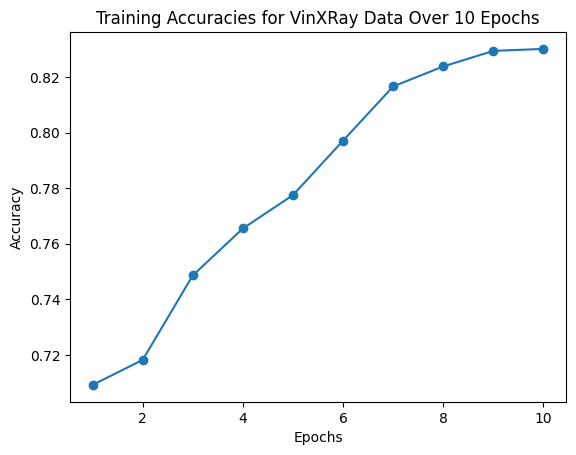

In [ ]:
training_accuracy = [0.7092, 0.7182, 0.7486, 0.7655, 0.7775, 0.7971, 0.8166, 0.8238, 0.8294, 0.8301]
epochs = range(1, 11)
plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracies for VinXRay Data Over 10 Epochs')


In [ ]:
# Evaluate the model
pred = model.predict(testData)
predicted_labels = np.round(pred)
accuracy = accuracy_score(testLabels, predicted_labels) * 100

print("Accuracy: {:.2f}%".format(accuracy))

ValueError: Expected input data to be non-empty.

In [ ]:
! ls /content/drive/MyDrive/Neuro140/vinxray/test_data/abnormal

In [ ]:
import os

train_data_dir = '/content/drive/MyDrive/Neuro140/vinxray/train_data/'
test_data_dir = '/content/drive/MyDrive/Neuro140/vinxray/test_data/'

num_train_classes = len(os.listdir(train_data_dir))
num_test_classes = len(os.listdir(test_data_dir))

print(f'Number of classes in train_data: {num_train_classes}')
print(f'Number of classes in test_data: {num_test_classes}')

Number of classes in train_data: 2
Number of classes in test_data: 2


In [ ]:
! ls -a /content/drive/MyDrive/Neuro140/vinxray/train_data/

abnormal  normal


**Remove Hidden Files**

In [ ]:
!rm -rf /content/drive/MyDrive/Neuro140/vinxray/train_data/.ipynb_checkpoints


In [ ]:
!rm -rf /content/drive/MyDrive/Neuro140/vinxray/test_data/.ipynb_checkpoints


In [ ]:
import os

def count_files_in_folder(folder_path):
    try:
        # Get the list of files in the folder
        files = os.listdir(folder_path)

        # Count the number of files
        num_files = len(files)

        # Print the result
        print(f'The folder "{folder_path}" contains {num_files} files.')

    except FileNotFoundError:
        print(f'The folder "{folder_path}" does not exist.')
    except PermissionError:
        print(f'Permission error accessing the folder "{folder_path}".')
    except Exception as e:
        print(f'An error occurred: {e}')

# Replace 'your_folder_path' with the actual path of the folder you want to check
count_files_in_folder('/content/drive/MyDrive/Neuro140/vinxray/train_data/abnormal')

The folder "/content/drive/MyDrive/Neuro140/vinxray/train_data/abnormal" contains 9210 files.
